In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn requests tf2onnx skl2onnx onnx onnxmltools keras_tuner

In [24]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 2.2 MB/s eta 0:00:00


Loading Test Data...
Evaluating Random Forest...
Evaluating XGBoost...


Evaluating lstm_model...
Evaluating cnn_model...


Evaluating transformer_model...
Standard load failed for Transformer (too many positional arguments). Attempting weight load fallback...
Generating final_model_report.xlsx...
Report generated successfully (Transposed format with Overall section).


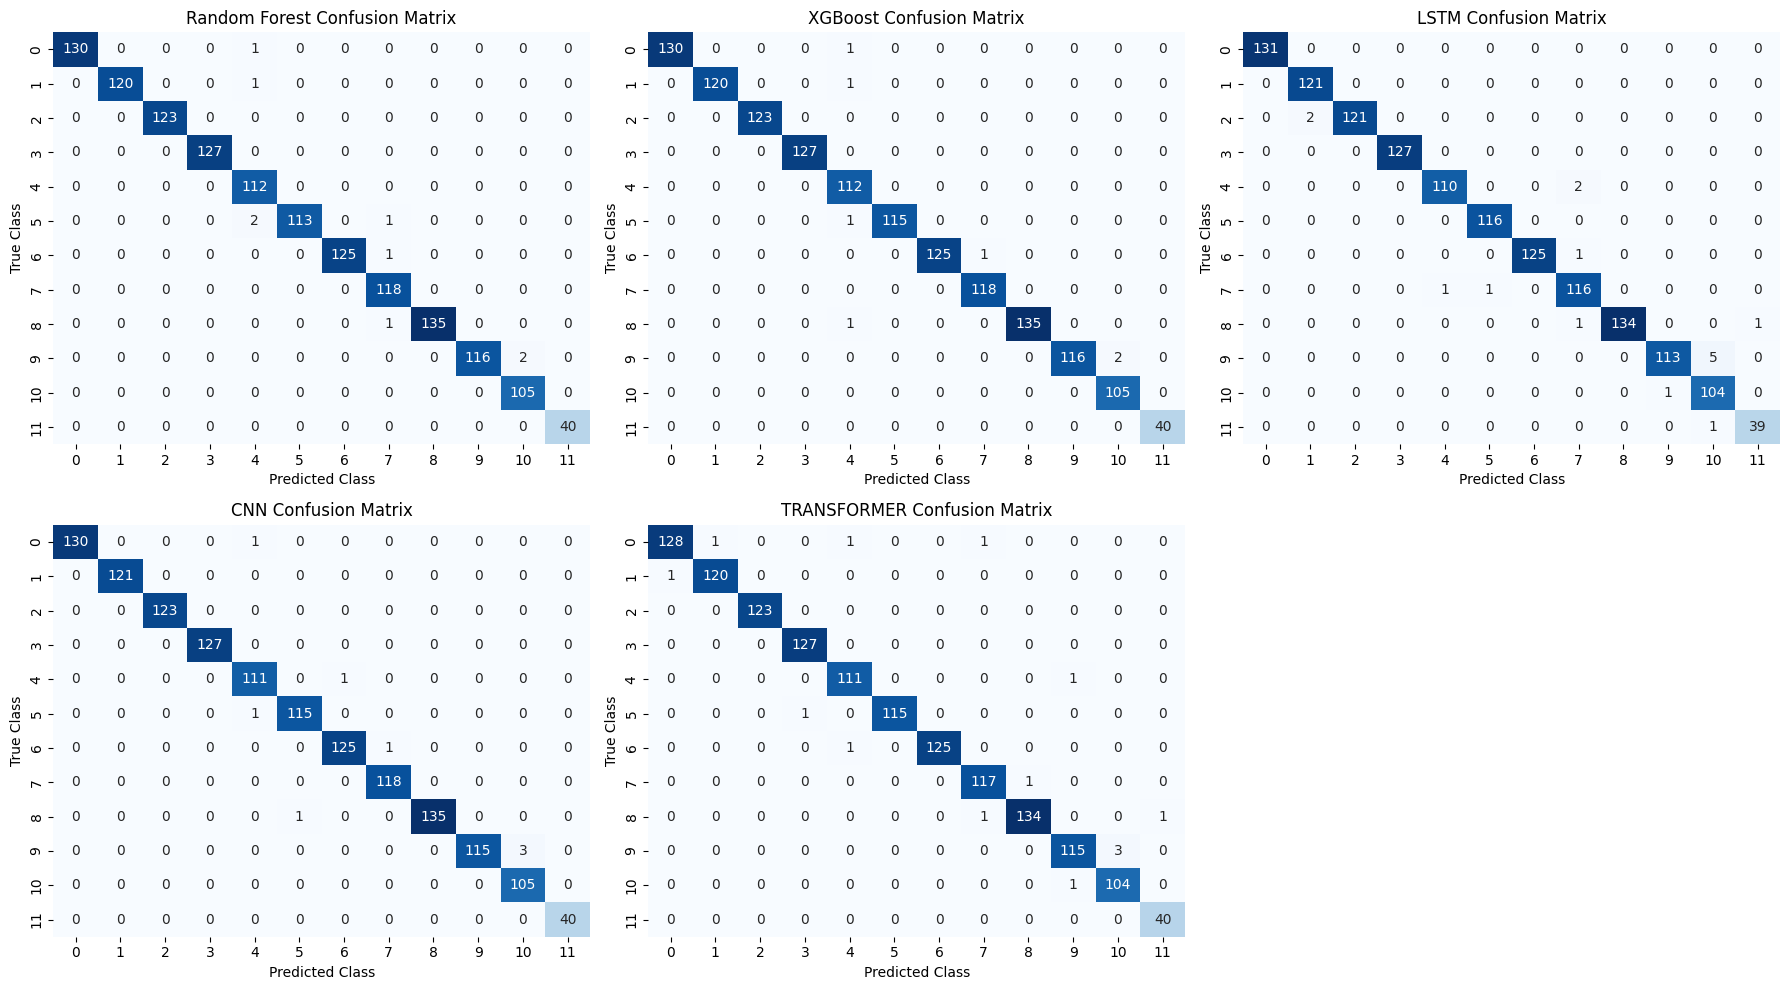

In [25]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xlsxwriter

# --- Configuration ---
PROCESSED_DIR = 'data/processed'
MODELS_DIR = 'models'
OUTPUT_REPORT = 'final_model_report.xlsx'

ACTIVITY_LABELS = {
    0: 'Standing', 1: 'Sitting', 2: 'Lying', 3: 'Walking',
    4: 'Stairs', 5: 'Bend Fwd', 6: 'Arms Up', 7: 'Knees Bend',
    8: 'Cycling', 9: 'Jogging', 10: 'Running', 11: 'Jump'
}

# --- Load Test Data ---
if os.path.exists(os.path.join(PROCESSED_DIR, 'X_test.npy')):
    print("Loading Test Data...")
    X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
    y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))

    # Prepare flattened version for RF/XGB
    X_test_flat = np.hstack([np.mean(X_test, axis=1), np.std(X_test, axis=1)])
else:
    print("Error: Test data not found. Please run 02-data-preprocessing.ipynb first.")
    exit()

# --- Helper: Metrics Calculation ---
def calculate_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate Macro Average Metrics (Overall)
    macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    metrics_list = []

    # Per-Class Metrics
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics_list.append({
            "Model": model_name,
            "Class ID": i,
            "Activity": ACTIVITY_LABELS.get(i, f"Class {i}"),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1-Score": round(f1, 4),
            "Support": tp + fn
        })

    df = pd.DataFrame(metrics_list)

    # Add Overall Metrics (Same for all rows of this model, useful for pivoting)
    df['Overall Accuracy'] = round(accuracy, 4)
    df['Macro Precision'] = round(macro_prec, 4)
    df['Macro Recall'] = round(macro_rec, 4)
    df['Macro F1'] = round(macro_f1, 4)

    return df, cm

# --- Helper: Transformer Architecture (Fallback for Loading) ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer_fallback(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=64, dropout=0.1)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(12, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# --- Evaluate Models ---
evaluation_results = []
confusion_matrices = {}

# 1. Evaluate RF
try:
    print("Evaluating Random Forest...")
    rf_path = os.path.join(MODELS_DIR, 'rf_model.joblib')
    if os.path.exists(rf_path):
        rf = joblib.load(rf_path)
        y_pred_rf = rf.predict(X_test_flat)
        df_rf, cm_rf = calculate_metrics(y_test, y_pred_rf, "Random Forest")
        evaluation_results.append(df_rf)
        confusion_matrices['Random Forest'] = cm_rf
    else:
        print(f"File not found: {rf_path}")
except Exception as e:
    print(f"Skipping RF: {e}")

# 2. Evaluate XGB
try:
    print("Evaluating XGBoost...")
    xgb_path = os.path.join(MODELS_DIR, 'xgb_model.joblib')
    if os.path.exists(xgb_path):
        xgb_mod = joblib.load(xgb_path)
        y_pred_xgb = xgb_mod.predict(X_test_flat)
        df_xgb, cm_xgb = calculate_metrics(y_test, y_pred_xgb, "XGBoost")
        evaluation_results.append(df_xgb)
        confusion_matrices['XGBoost'] = cm_xgb
    else:
        print(f"File not found: {xgb_path}")
except Exception as e:
    print(f"Skipping XGB: {e}")

# 3. Evaluate Deep Learning Models (Keras)
dl_models = ['lstm_model', 'cnn_model', 'transformer_model']

for name in dl_models:
    try:
        print(f"Evaluating {name}...")
        model_path = os.path.join(MODELS_DIR, f"{name}.h5")

        if os.path.exists(model_path):
            if name == 'transformer_model':
                # Special handling for Transformer: Rebuild and Load Weights
                try:
                    # Try standard load first
                    model = keras.models.load_model(model_path)
                except Exception as load_err:
                    print(f"Standard load failed for Transformer ({load_err}). Attempting weight load fallback...")
                    # Fallback: Build fresh model and load weights
                    model = build_transformer_fallback((100, 23))
                    # Note: load_weights can often read from the full H5 model file
                    model.load_weights(model_path)
            else:
                # Standard load for CNN/LSTM
                model = keras.models.load_model(model_path)

            preds = model.predict(X_test, verbose=0)
            y_pred = np.argmax(preds, axis=1)

            clean_name = name.replace('_model', '').upper()
            df_dl, cm_dl = calculate_metrics(y_test, y_pred, clean_name)
            evaluation_results.append(df_dl)
            confusion_matrices[clean_name] = cm_dl
        else:
            print(f"File not found: {model_path} - Ensure 04-modeling.ipynb ran successfully.")

    except Exception as e:
        print(f"Skipping {name}: {e}")

# --- Generate Outputs ---

# 1. Transposed Excel Report with Overall Section
if evaluation_results:
    print(f"Generating {OUTPUT_REPORT}...")

    # Combine all results
    full_df = pd.concat(evaluation_results, ignore_index=True)

    # --- Transformation Logic for Transposed View ---

    # 1. Melt Per-Class Metrics
    melted_class_df = full_df.melt(
        id_vars=['Model', 'Activity'],
        value_vars=['Precision', 'Recall', 'F1-Score', 'Support'],
        var_name='Metric',
        value_name='Value'
    )

    # 2. Melt Overall Metrics (Create "Overall" activity rows)
    overall_stats = full_df[['Model', 'Overall Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1']].drop_duplicates()
    melted_overall_df = overall_stats.melt(
        id_vars=['Model'],
        value_vars=['Overall Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1'],
        var_name='Metric',
        value_name='Value'
    )
    melted_overall_df['Activity'] = 'Overall'

    # 3. Combine both
    combined_melted = pd.concat([melted_class_df, melted_overall_df], ignore_index=True)

    # 4. Pivot to get Models as columns
    detailed_pivot = combined_melted.pivot_table(
        index=['Activity', 'Metric'],
        columns='Model',
        values='Value',
        aggfunc='first' # Should be unique per model/activity/metric
    )

    # 5. Reorder rows to ensure "Overall" is at the bottom
    # Get unique activities excluding 'Overall'
    activities = sorted([a for a in detailed_pivot.index.get_level_values(0).unique() if a != 'Overall'])
    # Reindex with activities sorted + Overall at the end
    new_order = activities + ['Overall']
    detailed_pivot = detailed_pivot.reindex(new_order, level=0)

    with pd.ExcelWriter(OUTPUT_REPORT, engine='xlsxwriter') as writer:
        # Sheet 1: Detailed Comparison (Transposed + Overall)
        detailed_pivot.to_excel(writer, sheet_name='Model Comparison')

        # Formatting (Auto-width)
        workbook = writer.book
        worksheet = writer.sheets['Model Comparison']
        format1 = workbook.add_format({'num_format': '0.0000'})

        # Apply formatting to all data columns
        n_models = len(full_df['Model'].unique())
        worksheet.set_column(2, n_models + 2, 15, format1)

    print("Report generated successfully (Transposed format with Overall section).")
else:
    print("No results to report.")

# 2. Plot Confusion Matrices
if confusion_matrices:
    n_models = len(confusion_matrices)
    cols = 3
    rows = (n_models + cols - 1) // cols

    plt.figure(figsize=(6 * cols, 5 * rows))

    for i, (name, cm) in enumerate(confusion_matrices.items(), 1):
        plt.subplot(rows, cols, i)
        # annot=True with fmt='d' ensures numbers are printed inside cells
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{name} Confusion Matrix")
        plt.ylabel('True Class')
        plt.xlabel('Predicted Class')

    plt.tight_layout()
    plt.savefig('all_confusion_matrices.png')
    plt.show()